In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer
from torch.utils.data import DataLoader, TensorDataset, Dataset
import scipy.stats as stats
from torchsummary import summary
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.base import BaseEstimator
from torchmetrics import MeanSquaredError, R2Score

## Load Data

In [2]:
df = pd.read_csv('./leap-atmospheric-physics-ai-climsim/train.csv', sep=',', nrows=1000000)

## Feature Selection

In [3]:
input_df = df.iloc[:, 1:557]
output_df = df.iloc[:, 557:]

In [4]:
# drop low variance with no correlation columns
no_corr_or_var = [523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 
                  543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 60, 61, 62, 67, 68, 69, 120, 121, 
                  122, 123, 180, 181, 182, 185, 186, 187, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 
                  475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495]
input_df_clean = input_df.drop(input_df.columns[no_corr_or_var], axis=1)
input_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Columns: 474 entries, state_t_0 to pbuf_N2O_26
dtypes: float64(474)
memory usage: 3.5 GB


## Setting up Mac GPU

In [5]:
# Swap to MacOS GPU via MPS
if torch.backends.mps.is_available():
   device = torch.device("mps")
   x = torch.ones(1, device=device)
   print (x)
else:
   print ("MPS device not found.")

tensor([1.], device='mps:0')


## Data Sets

In [6]:
X_array = input_df_clean.to_numpy(dtype=np.float32)
y_array = output_df.to_numpy(dtype=np.float32)

# split into train, validation, and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X_array, y_array, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# MinMaxScaler due to normal distribution test failing earlier
scaler = MinMaxScaler()
X_train_numpy = scaler.fit_transform(X_train)
X_val_numpy = scaler.transform(X_val)
X_test_numpy = scaler.transform(X_test)

# convert to tensors
X_train_tensor = torch.tensor(X_train_numpy, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_numpy, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_numpy, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

## Hyperparameters

In [7]:
input_size = X_train_tensor.shape[1]
hidden_size = 694
output_size = y_train_tensor.shape[1]
batch_size = 64
num_epochs = 80
learning_rate = 0.01
regularization_param = 0.0001
momentum_param = 0.9
dropout_p = 0.1

scheduler_factor = 0.1
scheduler_patience = 5

## Defining the model

In [8]:
# hidden layer function
def hidden_layer(hidden_size=hidden_size, dropout_p=dropout_p):
    return nn.Sequential(
        nn.Linear(hidden_size, hidden_size),
        nn.BatchNorm1d(hidden_size),
        nn.LeakyReLU(),
        nn.Dropout(dropout_p)
    )

# create model variable and input layer
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.LeakyReLU(),
    nn.Dropout(dropout_p),
)
# add hidden layers
for _ in range(3):
    model.add_module(str(len(model)), hidden_layer(hidden_size, dropout_p))
# add output layer
model.add_module(str(len(model)), nn.Linear(hidden_size, output_size))

# evaluation metrics
metric = R2Score(num_outputs=output_size).to(device=device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization_param)

# scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=scheduler_factor, patience=scheduler_patience)

# data loaders
train_dl = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size, shuffle=True)
val_dl = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size, shuffle=False)
test_dl = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size, shuffle=False)

## Running the model

In [9]:
train_losses = []
val_losses = []
r2_scores = []
patience_count = 0
best_loss = float('inf')
best_model = None
total_epochs = 0

model.to(device)

for epoch in range(num_epochs):
    total_epochs += 1

    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_dl:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        # Forward pass
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    all_outputs = torch.tensor([], dtype=torch.float32, device=device)
    all_targets = torch.tensor([], dtype=torch.float32, device=device)
    with torch.no_grad():
        for x_val, y_val in val_dl:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            val_loss += criterion(outputs, y_val).item()
            all_outputs = torch.cat((all_outputs, outputs), dim=0)
            all_targets = torch.cat((all_targets, y_val), dim=0)

    val_loss /= len(val_dl)
    val_losses.append(val_loss)

    # r2 score
    for i in range(output_size):
        metric.update(all_outputs[:, i], all_targets[:, i])
    r2_score = metric.compute()
    r2_scores.append(r2_score.item())
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, R2 Score: {r2_score:.4f}')

    # run scheduler
    scheduler.step(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        patience_count = 0
        best_model = model.state_dict()
        print('Validation loss improved. Saving model...\n')
    else:
        patience_count += 1
        if patience_count == scheduler_patience * 3:
            print('Training stopped. Patience count:', patience_count)
            break
        elif patience_count % scheduler_patience == 0:
            print('Reducing learning rate. Patience count:', patience_count)
        else:
            print("No improvement. Patience count:", patience_count)



Epoch [1/80], Train Loss: 14.2334, Val Loss: 11.2975, R2 Score: 0.9835
Validation loss improved. Saving model...

Epoch [2/80], Train Loss: 10.9809, Val Loss: 8.4339, R2 Score: 0.9856
Validation loss improved. Saving model...

Epoch [3/80], Train Loss: 10.4359, Val Loss: 9.1051, R2 Score: 0.9860
No improvement. Patience count: 1
Epoch [4/80], Train Loss: 10.1327, Val Loss: 7.5354, R2 Score: 0.9867
Validation loss improved. Saving model...

Epoch [5/80], Train Loss: 10.0338, Val Loss: 8.6899, R2 Score: 0.9868
No improvement. Patience count: 1
Epoch [6/80], Train Loss: 9.9004, Val Loss: 7.6103, R2 Score: 0.9872
No improvement. Patience count: 2
Epoch [7/80], Train Loss: 9.7649, Val Loss: 7.3755, R2 Score: 0.9875
Validation loss improved. Saving model...

Epoch [8/80], Train Loss: 9.8216, Val Loss: 7.4320, R2 Score: 0.9877
No improvement. Patience count: 1
Epoch [9/80], Train Loss: 9.7966, Val Loss: 6.9509, R2 Score: 0.9879
Validation loss improved. Saving model...

Epoch [10/80], Train L

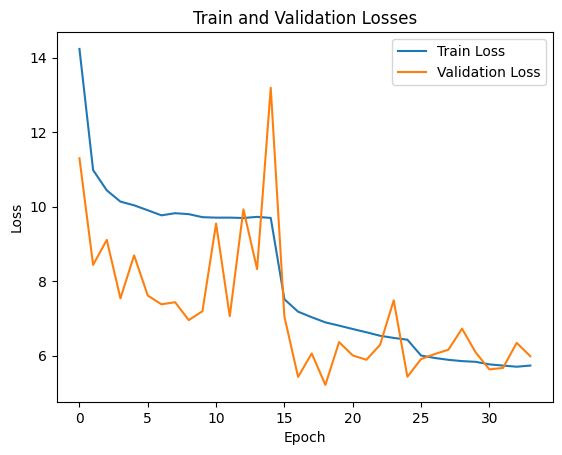

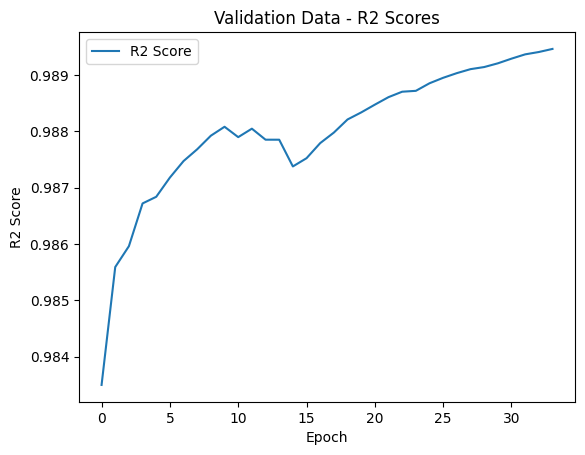

In [10]:
# Plotting train and validation losses
plt.plot(range(total_epochs), train_losses, label='Train Loss')
plt.plot(range(total_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.show()

# Plotting r2 scores
plt.plot(range(total_epochs), r2_scores, label='R2 Score')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.title('Validation Data - R2 Scores')
plt.legend()
plt.show()

## Testing the model

In [11]:
test_model = model
test_model.load_state_dict(best_model)

test_loss = 0.0
test_outputs = torch.tensor([], dtype=torch.float32, device=device)
test_targets = torch.tensor([], dtype=torch.float32, device=device)

test_model.eval()
with torch.no_grad():
    for x_test, y_test in test_dl:
        x_test, y_test = x_test.to(device), y_test.to(device)
        outputs = test_model(x_test)
        test_loss += criterion(outputs, y_test).item()
        test_outputs = torch.cat((test_outputs, outputs), dim=0)
        test_targets = torch.cat((test_targets, y_test), dim=0)

print("Test Data Set Results")
# loss
test_loss /= len(test_dl)
print(f"Test Loss: {test_loss:.4f}")

# r2 score
for i in range(output_size):
    metric.update(test_outputs[:, i], test_targets[:, i])
r2_score = metric.compute()

print(f"R2: {r2_score.item():.4f}")

Test Data Set Results
Test Loss: 6.0059
R2: 0.9895


## Saving the model

In [12]:
torch.save(best_model, 'PML_Best_Model.pt')